The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
24
Topic 0:
order receive fever rom spring nd collection big miss routine skin favourite dry asian pale
Topic 1:
jan lip tint asian box unpopular someone ban miss scam hair routine sunscreen 1yr bad
Topic 2:
joke life fair lab sunscreen round right real beauty fake left box nd ban detailed
Topic 3:
limited edition away know matte pale else eyeshadow jan haul favourite across dry fever hyperpigmentation
Topic 4:
charge guilty ant infest ban package subreddit mixsoon come across product many random sample detailed
Topic 5:
day haul marshall bad everything niacinamide add nd order someone cc miss big favourite wonyoung
Topic 6:
sensual dupe gloss hera receive ban haul tint left asian cc scam mask recommendation life
Topic 7:
inner wonyoung glow recommendation blush lot cc someone pih hyperpigmentation melano spring gloss black asian
Topic 8:
black scam friday opinion 1yr hair gal unpopular tsubaki let 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


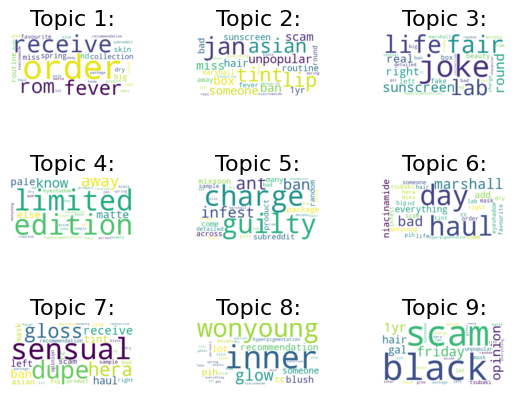

In [11]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

from redditClient import redditClient
import praw
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
import math
import json

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def processText(text, tokenizer, stopwords):
    text = text.lower()
    lTokens = tokenizer.tokenize(text)
    lTokens = [token.strip() for token in lTokens]
    lTokens = [lemmatizer.lemmatize(tok, get_wordnet_pos(tok)) for tok in lTokens]
    return [tok for tok in lTokens if tok not in stopwords and not tok.isdigit()]

client = redditClient()

postTokeniser = nltk.tokenize.TweetTokenizer()
lPunct = list(string.punctuation)
custom_stopwords = ['yesstyle', 'ab', 'review', 'comment', 'get', 'deal', 'item', 'anyone', 'plus', 'empty']
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['via'] + custom_stopwords

json_file = 'asian_beauty_top_200_2024.json'

with open(json_file, 'r', encoding='utf-8') as f:
    reddit_data = json.load(f)

lPosts = []

sentiment_file = 'sentimentScores.txt'

sentiment_scores = {}

with open(sentiment_file, 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith('Post:'):
            parts = line.strip().split('|')
            post_index = int(parts[0].split(':')[1].strip())
            sentiment_score = float(parts[1].split(':')[1].strip())
            sentiment_scores[post_index] = sentiment_score

numPostsAppended = 0
for i, submission in enumerate(reddit_data, start=1):
    if i in sentiment_scores and sentiment_scores[i] < 0:
        submissionTitle = submission['title']
        lTokens = processText(text=submissionTitle, tokenizer=postTokeniser, stopwords=lStopwords)
        lPosts.append(' '.join(lTokens))
        numPostsAppended += 1

print(numPostsAppended)

topicNum = 9
wordNumToDisplay = 15
featureNum = 3000

tfidfVectorizer = TfidfVectorizer(
    max_df=0.80, 
    min_df=1,
    max_features=featureNum,
    stop_words=lStopwords
)

tf = tfidfVectorizer.fit_transform(lPosts)
tfFeatureNames = tfidfVectorizer.get_feature_names_out()

ldaModel = LatentDirichletAllocation(n_components=topicNum, max_iter=25, learning_method='online').fit(tf)

def display_topics(model, featureNames, numTopWords):
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfidfVectorizer, mds='tsne')
pyLDAvis.display(panel)

def displayWordcloud(model, featureNames):
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topicNum = len(model.components_)
    plotColNum = 3
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i]: wordProb for i, wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='white', max_words=30)
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId + 1)
        plt.title('Topic %d:' % (topicId + 1), fontsize=16)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.subplots_adjust(wspace=0.5, hspace=0.8)
    plt.show(block=True)

displayWordcloud(ldaModel, tfFeatureNames)
